<a href="https://colab.research.google.com/github/kmjohnson3/ML4MI_Bootcamp_Development/blob/master/ImageSynthesis/ImageTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This tutorial will give an example application of using deep learning for medical image-to-image translation. This example will demonstrate how to transform a segmentation CNN into a regression CNN for the purpose of predicting T2 images from T1 images. 

Keep an eye out for questions through this demo to test your new DL knowledge and critical thinking. There are answers at the end of the document.

### Initial preparation

Import necessary modules

In [0]:
import os # operating system operations 

import tensorflow as tf
import matplotlib.pyplot as plt # for plotting our results

import numpy as np
np.random.seed(1) # set seed for random number generator

Next, we need to copy the files to a place where our CoLab notebook can read them.

In [2]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy data to this VM
import tarfile
from tqdm import tqdm
with tarfile.open(name='/content/drive/My Drive/ML4MI_BOOTCAMP_DATA/ImageSynthesis.tar') as tar:
    for member in tqdm(iterable=tar.getmembers(), desc='Decompressing', unit='file', total=len(tar.getmembers())):
      tar.extract(member=member,path='/home/')

Decompressing:   0%|          | 0/3 [00:00<?, ?file/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Decompressing: 100%|██████████| 3/3 [00:38<00:00, 12.97s/file]


# Data Preparation
All deep learning applications start with getting the data.

We made this one easy for you by compiling the data into an HDF5 file. We will be using MRI T1 images of the brain as inputs, and we wish to convert them to T2 images. All we have to do is load all of the inputs and targets and it will be ready to go.

First we import the python hdf5 library, h5py. Then we load all the individual datasets in and convert them to Numpy arrays. This will take a few seconds.

In [0]:
# load training, validation, and testing data
# adding a singleton dimension
import h5py
with h5py.File('/home/ImageSynthesis/data/ImageTranslationData.hdf5','r') as hf:
    trainX = np.array(hf.get("trainX"))[...,np.newaxis]
    trainY = np.array(hf.get("trainY"))[...,np.newaxis]
    valX = np.array(hf.get("valX"))[...,np.newaxis]
    valY = np.array(hf.get("valY"))[...,np.newaxis]
    testX = np.array(hf.get("testX"))[...,np.newaxis]
    testY = np.array(hf.get("testY"))[...,np.newaxis]

##### Question 1: What is the purpose of the training, validation, and testing datasets?

This time, we will use an ImageDataGenerator so we can augment data on the fly. Before, we used this on a directory to make loading in image data from directories a breeze. However, that only works for classification schemes. For this image to image translation problem, we first had to load all the data into an array. Already did it!

Next, we have to setup two generators, one for the input images and one for the target images. Then we will synchronize the generators so they are always creating augmented inputs and targets that match up for training.

We have already set these up for you, but it is helpful to look through all the different parameters that are set in the augmentation.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# setup image data generator
datagen1 = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
datagen2 = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

# Provide the same seed and keyword arguments to the fit and flow
# in order to synchronize the inputs and targets
seed = 1
datagen1.fit(trainX, seed=seed)
datagen2.fit(trainY, seed=seed)
# set batch size
batchsize = 16

# combine the two datagets into one that simultaneously
# provides both input and target image
def combine_generator(a,b):
  while True:
    yield(a.next(), b.next())
    
train_generator = combine_generator( datagen1.flow( trainX, None, batchsize, seed=seed),
                                     datagen2.flow( trainY, None, batchsize, seed=seed))

# calculate how many steps per epoch
# If we set it to
# number of samples / batch size
# then we'll see each training example once per epoch
# which is what we want
steps = np.int(trainX.shape[0]/batchsize)

It's always a good to check that our data loaded correctly and the inputs correspond to the target images. It is especially important to make sure our data generators are doing what we intend.

The below cell asks the data generator for its next batch, then displays the first image of the input and target in the batch. Run it a couple times to see the different augmentations that the generator is doing.

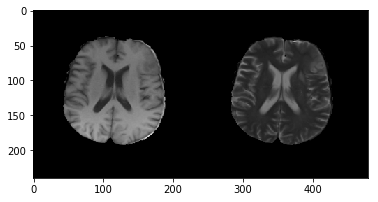

In [5]:
dispX,dispY = next(train_generator)
plt.figure()
disp = np.c_[dispX[0,...,0],
             dispY[0,...,0]]
plt.imshow(disp,cmap='gray')
plt.show()

# Transforming Segmentation Network into Translation Network

We have already built a segmentation CNN in the convolutional encoder-decoder format. This is exactly what we need for image to image translation since our targets are equivalent in size to our inputs.

However, there are some changes we need to make. Our output is continuous rather than binary. This means:
1. We want a continuous output that isn't squashed by a sigmoid function
2. We need a loss function that works with regression error, not overlap error like Dice

We will start with the previously made network that has skip connections and had good performance on the segmentation task. 

Let's get to work!

We have already imported keras, so we don't technically need to import anything. It keep code a lot cleaner to individually import layers, so we'll do that again.

In [0]:
# import keras layers
from tensorflow.keras.layers import Input,Conv2D,ZeroPadding2D
from tensorflow.keras.layers import concatenate,Conv2DTranspose
from tensorflow.keras.models import Model

Below is the code used to define the segmentation network in the previous example, including the use of skip connections. Make the appropriate alterations to this code as described above to transform it into a image-to-image translation model.

In [0]:
inp = Input(shape=trainX.shape[1:])
init = 'he_normal'
x = Conv2D(10,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(inp)
x1 = Conv2D(20, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
zp = ZeroPadding2D(padding=(1,1))(x1)
x = Conv2D(30, kernel_size=(4,4),
                strides=(2,2),
                activation='relu',
                kernel_initializer=init)(zp)
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x2 = Conv2D(40, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
zp = ZeroPadding2D(padding=(1,1))(x2)
x = Conv2D(40, kernel_size=(4,4),
                strides=(2,2),
                activation='relu',
                kernel_initializer=init)(zp)
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2DTranspose(40, kernel_size=(4,4),
                        strides=(2,2),
                        activation='relu',
                        kernel_initializer=init)(x)
x = Conv2D(40, kernel_size=(3,3),activation='relu',kernel_initializer=init)(x)
x = concatenate([x,x2])
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2DTranspose(20, kernel_size=(4,4),
                        strides=(2,2),
                        activation='relu',
                        kernel_initializer=init)(x)
x = Conv2D(20, kernel_size=(3,3),activation='relu',kernel_initializer=init)(x)
x = concatenate([x,x1])
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)

# Final output layer
out = Conv2D(1,kernel_size=(1,1),activation='linear',kernel_initializer=init)(x)

RegModel = Model(inp,out)

Next, define the loss function you wish to use for this problem

In [0]:
loss = tf.keras.losses.mean_absolute_error

##### Question 2: What are the consequences of difference loss functions for this task?

Finally, add an optimizer and compile the model

In [0]:
opt = tf.keras.optimizers.Adam()

RegModel.compile(loss=loss,optimizer=opt)

Now all you have to do is call your compiled model on this data generator. Here's the syntax:

`hist = Model.fit_generator(DataGenerator, steps_per_epoch,epochs,validation_data=(x,y)`

Fill in the syntax with the parameters we calculated above, set the epochs to 5, and let it run

In [10]:
hist = RegModel.fit_generator(train_generator,steps_per_epoch=steps,epochs=5, validation_data=(valX,valY))

Epoch 1/5
338/338 [==============================] - 64s 188ms/step - loss: 0.0232 - val_loss: 0.0201
Epoch 2/5
338/338 [==============================] - 54s 160ms/step - loss: 0.0199 - val_loss: 0.0171
Epoch 3/5
338/338 [==============================] - 54s 161ms/step - loss: 0.0195 - val_loss: 0.0179
Epoch 4/5
338/338 [==============================] - 55s 163ms/step - loss: 0.0191 - val_loss: 0.0172
Epoch 5/5
338/338 [==============================] - 56s 164ms/step - loss: 0.0188 - val_loss: 0.0167


### Evaluate Model
After the training is complete, we evaluate the model on our test data to see the results.

In [11]:
# Get the loss from evaluating the model and print it out
score = RegModel.evaluate(testX, testY, verbose=0)
print('Final loss on test set: {:.03e}'.format(score))

Final loss on test set: 1.674e-02


Plot the loss curves too:

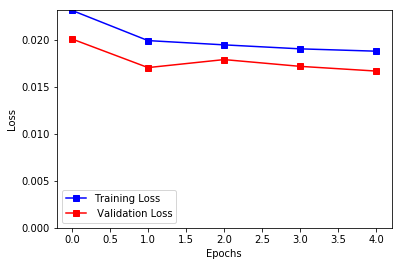

In [12]:
# Plot the losses that are stored in the 'hist' variable
plt.figure(figsize=(6.0, 4.0));
plt.plot(hist.epoch,hist.history['loss'],'b-s')
plt.plot(hist.epoch,hist.history['val_loss'],'r-s')
plt.legend(['Training Loss',
            ' Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,np.max(hist.history['loss'])])
plt.show()

Another useful way to evaluate a model is to just look at the outputs. We can look at a sample image to see how the images look compared to the ground truth.

In [0]:
# Get the predictions of the model on the test inputs
predictions = RegModel.predict(testX)

We'll display the input image, output image, ground truth image, and the difference image in a 2x2 grid. We'll add labels just to make it easier to know what we are looking at.

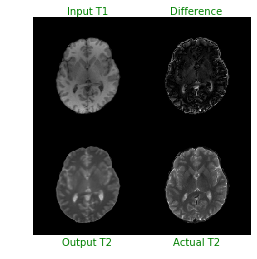

In [14]:
# pick a random slice to examine
disp_ind = 40
# get the T1 image, and the target mask
image = testX[disp_ind,...,0]
# get the model predicted T2 image
predicted_image = predictions[disp_ind,...,0]
# get the actual T2 image
truth_image = testY[disp_ind,...,0]
# get the absolute difference image
diff_image = np.abs(predicted_image-truth_image)
# normalize different image
diff_image /= np.max(diff_image)
# create a figure
fig = plt.figure()
ax = fig.add_subplot(111)
# combine images together into
# 2 by 2 grid
disp1 = np.c_[image,diff_image]
disp2 = np.c_[predicted_image,truth_image]
disp = np.r_[disp1,disp2]
# display image
plt.imshow(disp,cmap='gray')
# turn axis off
plt.axis('off')
# add labels to keep track of
# which images are which
ax.text(0.25, 1.01, 'Input T1',
         horizontalalignment='center',
        transform=ax.transAxes,
        color='green', fontsize=10)
ax.text(0.75, 1.01, 'Difference',
         horizontalalignment='center',
        transform=ax.transAxes,
        color='green', fontsize=10)
ax.text(0.25, -.05, 'Output T2',
         horizontalalignment='center',
        transform=ax.transAxes,
        color='green', fontsize=10)
ax.text(0.75, -.05, 'Actual T2',
         horizontalalignment='center',
        transform=ax.transAxes,
        color='green', fontsize=10)
plt.show()

Results will vary here. It's unlikely to be perfect. However, you can probably notice some of the contrast patterns are starting to align with the target image, and likely there are a few concentrated areas of error in the difference image. You could definitely train this model longer and get better results!

##### Question 3: What do you notice about the input and target images? Look closely, and compare to the output image

## Future Directions

In the last few years, a specialized type of deep learning model known as GANs have taken over image-to-image translation problems. GAN stands for Generative Adversarial Network. There are lots of resources online, but we'll provide a quick breakdown of them here in the context of medical imaging.

  - Generative: The model contains a "generator" that is responsible for turning the input image into the target image. The network we used for this example would serve as the generator.
  - Adversarial: There is a second part of the model known as a "discriminator". The job of this discriminator is to determine whether an image that it is given is real or "fake": produced by the generator. It takes the form of a classification network that classifies the test image as real or fake. The score of the discriminator is used as the loss of the generator. Thus, these networks battle against each other in an adversarial way.
    
Initially, the generator will not produce very good images- T2 images for this example. The discriminator will easily tell the difference between real T2 and generator-produced T2 images, and the generator's loss will be high. However, the generator will learn from this loss and start producing better looking T2 images. Eventually, the generator will produce T2 images that are indistinguishable from real T2 images.

There have been 100s of versions of different GANs developed. If you can use image-to-image translation in your work, they are definitely an area to explore.

## End of Image To Image Translation Example. Happy deep learning!

## Answers to Questions
#### 1- What is the purpose of the training, validation, and testing datasets?

* Training: These data are fed into the model, the loss is calculated on the results, and the weights in the network are updated based on that loss.
* Validation: This dataset is checked at the end of every epoch, and is used to determine whether the model is overfitting the training data or is learning more general features that can apply to broader data.
* Testing: Since the model sees the validation data during the course of training, a testing datset is occasionally kept separate and checked at the end of training for a truly independent measure of the model's performance.
    
#### 2- What are the consequences of different loss functions for this task?

There are two main choices for this regression task: mean squared error or mean absolute error. There are mathematical differences in what each error encourages the model to learn.

Mean square error encourages the output to be averaged. When there are multiple possible targets for given inputs to the model, it will learn to produce the average of these outputs. This results in smooth and sometimes blurry results.

Mean absolute error encourages the output to be a median. This is usually better for image tasks. It can still produce blurry outputs in areas of uncertainty, but generally does a better job of preserving edges and subtler features.


#### 3- What do you notice about the input and target images?

Depending on which slice you chose to display, you can likely notice that there are imperfections in the registration of the input and target images- they aren't perfectly lined up. This is a common problem in medical imaging. For image-to-image translation tasks, it means that no matter how good your model is, there won't be a perfect solution. In fact, you might notice that the model's output aligns more closely with the input. This makes sense- the model has no idea that there are registration problems- it's just trying to convert one image to look like another.

If there are systematic registration problems (e.g. output is shifted, rotated from input) then the model will learn this bias and implement that in its solutions. If the problems are random, it likely won't be able to replicate them,  and be a little blurry instead.

If you are interested in the state-of-the-art solutions to registration problems, search for "CycleGANs".
